<a href="https://colab.research.google.com/github/Odaenethus/CFD-simulations-google-collab-/blob/main/Unconstrained%20nonlinear%20optimisation%20on%20Rosenbrock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Results (Variant B) ===
Columns: method | x0 | status | iters | f_final | ||grad|| | x_final
Landweber                | [-1.20,  1.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [-1.20,  1.00] | converged(grad)    |  19435 | 6.106586e-17 | 9.996831e-09 | [1.000000, 1.000000]
Newton                   | [-1.20,  1.00] | converged(grad)    |      7 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [-1.20,  1.00] | converged(grad)    |     13 | 1.9348304e-17 | 3.9311457e-09 | [1.000000, 1.000000]
Landweber                | [ 0.00,  0.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [ 0.00,  0.00] | max_iter           |  20000 | 1.3710153e-16 | 2.4931985e-08 | [1.000000, 1.000000]
Newton                   | [ 0.00,  0.00] | converged(grad)    |      2 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [ 0.00,  0.

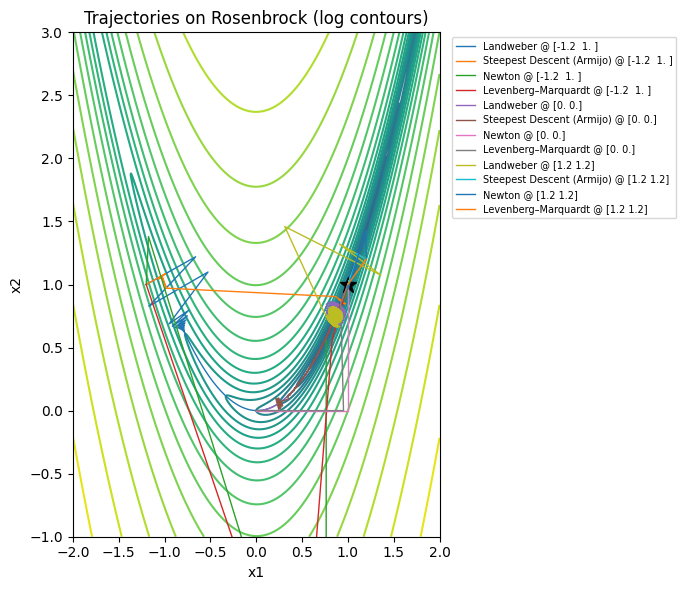

In [ ]:
# =========================
# Google Colab: HW#3 Variant B
# Unconstrained Nonlinear Optimization on Rosenbrock
# Methods: Landweber, Steepest Descent (line search), Newton, Levenberg–Marquardt
# Variant B: alpha = 0.005 (Landweber), mu = 0.05 (LM)
# =========================

import numpy as np

# ---------- Problem definition ----------
def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2

def grad_f(x):
    x1, x2 = x
    g1 = 2*(x1 - 1) - 400*x1*(x2 - x1**2)
    g2 = 200*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess_f(x):
    x1, x2 = x
    h11 = 2 - 400*(x2 - x1**2) + 800*(x1**2)
    h12 = -400*x1
    h22 = 200.0
    return np.array([[h11, h12],
                     [h12, h22]], dtype=float)

def F(x):
    x1, x2 = x
    return np.array([1 - x1, 10.0*(x2 - x1**2)], dtype=float)

def J(x):
    x1, x2 = x
    # Jacobian of F:
    # F1 = 1 - x1        => dF1/dx1 = -1, dF1/dx2 = 0
    # F2 = 10(x2 - x1^2) => dF2/dx1 = -20 x1, dF2/dx2 = 10
    return np.array([[-1.0,      0.0],
                     [-20.0*x1, 10.0]], dtype=float)

def norm2(v):
    return float(np.linalg.norm(v, ord=2))

def run_template(method_name, x0, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    """
    Generic runner: expects a 'step_fn' returning (x_next, info_dict)
    We'll implement per-method runners separately for clarity.
    """
    raise NotImplementedError

def summarize_run(hist):
    # hist: dict with keys: x_path, f_path, status, iters, extra
    x_final = hist["x_path"][-1]
    return {
        "status": hist["status"],
        "iters": hist["iters"],
        "x_final": x_final,
        "f_final": hist["f_path"][-1],
        "grad_norm": norm2(grad_f(x_final)),
        **hist.get("extra", {})
    }

#  Method 1: Landweber
def landweber(x0, alpha=0.005, max_iter=20000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        # x_{k+1} = x_k - alpha * J^T F
        step = -alpha * (Jx.T @ Fx)
        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Landweber",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"alpha": alpha}
    }

# Method 2: Steepest Descent with Armijo backtracking
def steepest_descent(x0, max_iter=20000, tol_g=1e-8, tol_step=1e-12,
                     alpha0=1.0, c=1e-4, rho=0.5, max_ls=50):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    zigzag_hint = 0

    for k in range(max_iter):
        g = grad_f(x)
        gnorm = norm2(g)
        if gnorm < tol_g:
            status = "converged(grad)"
            break

        d = -g
        fx = f_path[-1]

        # Armijo backtracking line search
        alpha = alpha0
        ok = False
        for _ in range(max_ls):
            x_try = x + alpha * d
            if f(x_try) <= fx + c * alpha * (g @ d):
                ok = True
                break
            alpha *= rho

        if not ok:
            status = "line_search_failed"
            break

        step = alpha * d
        x_new = x + step

        # crude zig-zag indicator: if direction changes a lot
        if k >= 1:
            prev_step = x_path[-1] - x_path[-2]
            if norm2(prev_step) > 0 and norm2(step) > 0:
                cosang = float((prev_step @ step) / (norm2(prev_step)*norm2(step)))
                if cosang < -0.2:
                    zigzag_hint += 1

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Steepest Descent (Armijo)",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"zigzag_events": zigzag_hint}
    }

# Method 3: Newton
def newton_method(x0, max_iter=200, tol_g=1e-10, tol_step=1e-12, damping=1.0):
    """
    Plain Newton (can fail). Optional simple damping factor (1.0 = none).
    """
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    failures = 0

    for k in range(max_iter):
        g = grad_f(x)
        if norm2(g) < tol_g:
            status = "converged(grad)"
            break

        H = hess_f(x)

        try:
            # Solve H p = g; step = -p
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            status = "hessian_singular"
            failures += 1
            break

        step = -damping * p
        x_new = x + step

        # If f explodes, mark unstable and stop (assignment says it's OK if it fails)
        if not np.isfinite(f(x_new)) or f(x_new) > 1e12:
            status = "unstable(diverged)"
            break

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Newton",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"damping": damping, "failures": failures}
    }

# Method 4: Levenberg–Marquardt
def levenberg_marquardt(x0, mu=0.05, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    I = np.eye(2, dtype=float)

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        JTJ = Jx.T @ Jx
        g_ls = Jx.T @ Fx  # gradient of (1/2)||F||^2 up to constant; fine for stopping

        # step = -(JTJ + mu I)^{-1} J^T F
        A = JTJ + mu * I
        try:
            step = -np.linalg.solve(A, g_ls)
        except np.linalg.LinAlgError:
            status = "linear_solve_failed"
            break

        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Levenberg–Marquardt",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"mu": mu}
    }

# Run all methods on all initial points
initial_points = [
    np.array([-1.2, 1.0]),
    np.array([ 0.0, 0.0]),
    np.array([ 1.2, 1.2]),
]

alpha_B = 0.005
mu_B = 0.05

runs = []
for x0 in initial_points:
    runs.append(landweber(x0, alpha=alpha_B))
    runs.append(steepest_descent(x0))
    runs.append(newton_method(x0))  # plain Newton; allowed to fail
    runs.append(levenberg_marquardt(x0, mu=mu_B))

# Print a compact results table
def fmt(v, nd=6):
    if isinstance(v, (float, np.floating)):
        return f"{v:.{nd}g}"
    return str(v)

print("=== Results (Variant B) ===")
print("Columns: method | x0 | status | iters | f_final | ||grad|| | x_final")
for r in runs:
    s = summarize_run(r)
    x0 = r["x0"]
    print(
        f"{r['method']:<24} | "
        f"[{x0[0]:>5.2f}, {x0[1]:>5.2f}] | "
        f"{s['status']:<18} | "
        f"{s['iters']:>6d} | "
        f"{fmt(s['f_final'], 8):>10} | "
        f"{fmt(s['grad_norm'], 8):>10} | "
        f"[{s['x_final'][0]:.6f}, {s['x_final'][1]:.6f}]"
    )


import matplotlib.pyplot as plt

# Contour plot of Rosenbrock
x1 = np.linspace(-2, 2, 600)
x2 = np.linspace(-1, 3, 600)
X1, X2 = np.meshgrid(x1, x2)
Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

plt.figure(figsize=(7,6))
plt.contour(X1, X2, np.log10(Z + 1e-3), levels=30)
plt.plot(1, 1, 'k*', markersize=12)

for r in runs:
    path = np.array(r["x_path"])
    plt.plot(path[:,0], path[:,1], linewidth=1, label=f"{r['method']} @ {r['x0']}")

plt.xlim(-2, 2)
plt.ylim(-1, 3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Trajectories on Rosenbrock (log contours)")
plt.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

=== Results (Variant B) ===
Columns: method | x0 | status | iters | f_final | ||grad|| | x_final
Landweber                | [-1.20,  1.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [-1.20,  1.00] | converged(grad)    |  19435 | 6.106586e-17 | 9.996831e-09 | [1.000000, 1.000000]
Newton                   | [-1.20,  1.00] | converged(grad)    |      7 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [-1.20,  1.00] | converged(grad)    |     13 | 1.9348304e-17 | 3.9311457e-09 | [1.000000, 1.000000]
Landweber                | [ 0.00,  0.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [ 0.00,  0.00] | max_iter           |  20000 | 1.3710153e-16 | 2.4931985e-08 | [1.000000, 1.000000]
Newton                   | [ 0.00,  0.00] | converged(grad)    |      2 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [ 0.00,  0.

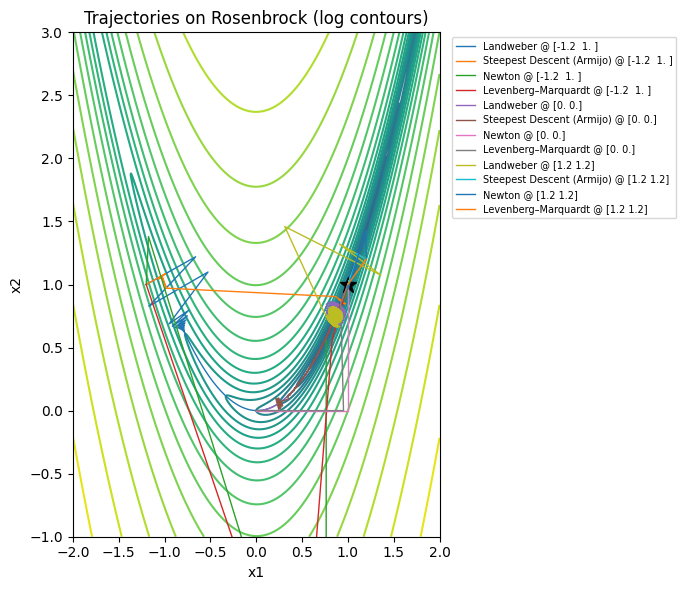

In [ ]:
# =========================
# Google Colab: HW#3 Variant B
# Unconstrained Nonlinear Optimization on Rosenbrock
# Methods: Landweber, Steepest Descent (line search), Newton, Levenberg–Marquardt
# Variant B: alpha = 0.005 (Landweber), mu = 0.05 (LM)
# =========================

import numpy as np

# ---------- Problem definition ----------
def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2

def grad_f(x):
    x1, x2 = x
    g1 = 2*(x1 - 1) - 400*x1*(x2 - x1**2)
    g2 = 200*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess_f(x):
    x1, x2 = x
    h11 = 2 - 400*(x2 - x1**2) + 800*(x1**2)
    h12 = -400*x1
    h22 = 200.0
    return np.array([[h11, h12],
                     [h12, h22]], dtype=float)

def F(x):
    x1, x2 = x
    return np.array([1 - x1, 10.0*(x2 - x1**2)], dtype=float)

def J(x):
    x1, x2 = x
    # Jacobian of F:
    # F1 = 1 - x1        => dF1/dx1 = -1, dF1/dx2 = 0
    # F2 = 10(x2 - x1^2) => dF2/dx1 = -20 x1, dF2/dx2 = 10
    return np.array([[-1.0,      0.0],
                     [-20.0*x1, 10.0]], dtype=float)

def norm2(v):
    return float(np.linalg.norm(v, ord=2))

def run_template(method_name, x0, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    """
    Generic runner: expects a 'step_fn' returning (x_next, info_dict)
    We'll implement per-method runners separately for clarity.
    """
    raise NotImplementedError

def summarize_run(hist):
    # hist: dict with keys: x_path, f_path, status, iters, extra
    x_final = hist["x_path"][-1]
    return {
        "status": hist["status"],
        "iters": hist["iters"],
        "x_final": x_final,
        "f_final": hist["f_path"][-1],
        "grad_norm": norm2(grad_f(x_final)),
        **hist.get("extra", {})
    }

#  Method 1: Landweber
def landweber(x0, alpha=0.005, max_iter=20000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        # x_{k+1} = x_k - alpha * J^T F
        step = -alpha * (Jx.T @ Fx)
        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Landweber",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"alpha": alpha}
    }

# Method 2: Steepest Descent with Armijo backtracking
def steepest_descent(x0, max_iter=20000, tol_g=1e-8, tol_step=1e-12,
                     alpha0=1.0, c=1e-4, rho=0.5, max_ls=50):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    zigzag_hint = 0

    for k in range(max_iter):
        g = grad_f(x)
        gnorm = norm2(g)
        if gnorm < tol_g:
            status = "converged(grad)"
            break

        d = -g
        fx = f_path[-1]

        # Armijo backtracking line search
        alpha = alpha0
        ok = False
        for _ in range(max_ls):
            x_try = x + alpha * d
            if f(x_try) <= fx + c * alpha * (g @ d):
                ok = True
                break
            alpha *= rho

        if not ok:
            status = "line_search_failed"
            break

        step = alpha * d
        x_new = x + step

        # crude zig-zag indicator: if direction changes a lot
        if k >= 1:
            prev_step = x_path[-1] - x_path[-2]
            if norm2(prev_step) > 0 and norm2(step) > 0:
                cosang = float((prev_step @ step) / (norm2(prev_step)*norm2(step)))
                if cosang < -0.2:
                    zigzag_hint += 1

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Steepest Descent (Armijo)",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"zigzag_events": zigzag_hint}
    }

# Method 3: Newton
def newton_method(x0, max_iter=200, tol_g=1e-10, tol_step=1e-12, damping=1.0):
    """
    Plain Newton (can fail). Optional simple damping factor (1.0 = none).
    """
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    failures = 0

    for k in range(max_iter):
        g = grad_f(x)
        if norm2(g) < tol_g:
            status = "converged(grad)"
            break

        H = hess_f(x)

        try:
            # Solve H p = g; step = -p
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            status = "hessian_singular"
            failures += 1
            break

        step = -damping * p
        x_new = x + step

        # If f explodes, mark unstable and stop (assignment says it's OK if it fails)
        if not np.isfinite(f(x_new)) or f(x_new) > 1e12:
            status = "unstable(diverged)"
            break

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Newton",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"damping": damping, "failures": failures}
    }

# Method 4: Levenberg–Marquardt
def levenberg_marquardt(x0, mu=0.05, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    I = np.eye(2, dtype=float)

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        JTJ = Jx.T @ Jx
        g_ls = Jx.T @ Fx  # gradient of (1/2)||F||^2 up to constant; fine for stopping

        # step = -(JTJ + mu I)^{-1} J^T F
        A = JTJ + mu * I
        try:
            step = -np.linalg.solve(A, g_ls)
        except np.linalg.LinAlgError:
            status = "linear_solve_failed"
            break

        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Levenberg–Marquardt",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"mu": mu}
    }

# Run all methods on all initial points
initial_points = [
    np.array([-1.2, 1.0]),
    np.array([ 0.0, 0.0]),
    np.array([ 1.2, 1.2]),
]

alpha_B = 0.005
mu_B = 0.05

runs = []
for x0 in initial_points:
    runs.append(landweber(x0, alpha=alpha_B))
    runs.append(steepest_descent(x0))
    runs.append(newton_method(x0))  # plain Newton; allowed to fail
    runs.append(levenberg_marquardt(x0, mu=mu_B))

# Print a compact results table
def fmt(v, nd=6):
    if isinstance(v, (float, np.floating)):
        return f"{v:.{nd}g}"
    return str(v)

print("=== Results (Variant B) ===")
print("Columns: method | x0 | status | iters | f_final | ||grad|| | x_final")
for r in runs:
    s = summarize_run(r)
    x0 = r["x0"]
    print(
        f"{r['method']:<24} | "
        f"[{x0[0]:>5.2f}, {x0[1]:>5.2f}] | "
        f"{s['status']:<18} | "
        f"{s['iters']:>6d} | "
        f"{fmt(s['f_final'], 8):>10} | "
        f"{fmt(s['grad_norm'], 8):>10} | "
        f"[{s['x_final'][0]:.6f}, {s['x_final'][1]:.6f}]"
    )


import matplotlib.pyplot as plt

# Contour plot of Rosenbrock
x1 = np.linspace(-2, 2, 600)
x2 = np.linspace(-1, 3, 600)
X1, X2 = np.meshgrid(x1, x2)
Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

plt.figure(figsize=(7,6))
plt.contour(X1, X2, np.log10(Z + 1e-3), levels=30)
plt.plot(1, 1, 'k*', markersize=12)

for r in runs:
    path = np.array(r["x_path"])
    plt.plot(path[:,0], path[:,1], linewidth=1, label=f"{r['method']} @ {r['x0']}")

plt.xlim(-2, 2)
plt.ylim(-1, 3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Trajectories on Rosenbrock (log contours)")
plt.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

=== Results (Variant B) ===
Columns: method | x0 | status | iters | f_final | ||grad|| | x_final
Landweber                | [-1.20,  1.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [-1.20,  1.00] | converged(grad)    |  19435 | 6.106586e-17 | 9.996831e-09 | [1.000000, 1.000000]
Newton                   | [-1.20,  1.00] | converged(grad)    |      7 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [-1.20,  1.00] | converged(grad)    |     13 | 1.9348304e-17 | 3.9311457e-09 | [1.000000, 1.000000]
Landweber                | [ 0.00,  0.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [ 0.00,  0.00] | max_iter           |  20000 | 1.3710153e-16 | 2.4931985e-08 | [1.000000, 1.000000]
Newton                   | [ 0.00,  0.00] | converged(grad)    |      2 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [ 0.00,  0.

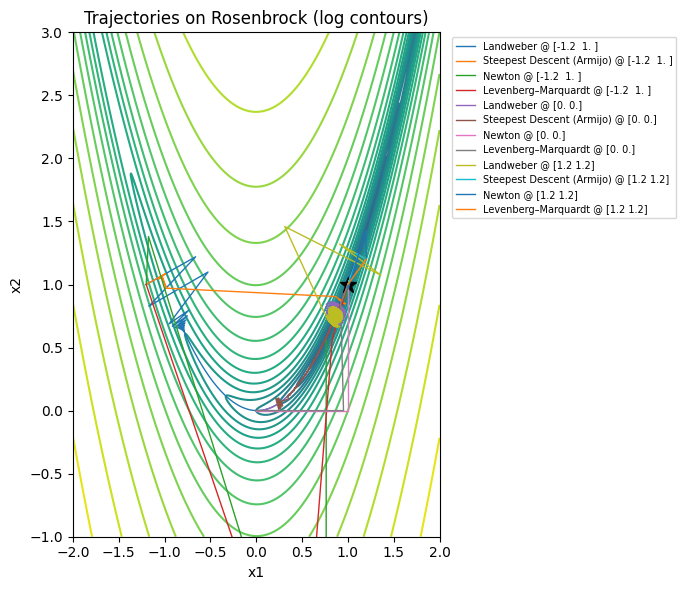

In [ ]:
# =========================
# Google Colab: HW#3 Variant B
# Unconstrained Nonlinear Optimization on Rosenbrock
# Methods: Landweber, Steepest Descent (line search), Newton, Levenberg–Marquardt
# Variant B: alpha = 0.005 (Landweber), mu = 0.05 (LM)
# =========================

import numpy as np

# ---------- Problem definition ----------
def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2

def grad_f(x):
    x1, x2 = x
    g1 = 2*(x1 - 1) - 400*x1*(x2 - x1**2)
    g2 = 200*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess_f(x):
    x1, x2 = x
    h11 = 2 - 400*(x2 - x1**2) + 800*(x1**2)
    h12 = -400*x1
    h22 = 200.0
    return np.array([[h11, h12],
                     [h12, h22]], dtype=float)

def F(x):
    x1, x2 = x
    return np.array([1 - x1, 10.0*(x2 - x1**2)], dtype=float)

def J(x):
    x1, x2 = x
    # Jacobian of F:
    # F1 = 1 - x1        => dF1/dx1 = -1, dF1/dx2 = 0
    # F2 = 10(x2 - x1^2) => dF2/dx1 = -20 x1, dF2/dx2 = 10
    return np.array([[-1.0,      0.0],
                     [-20.0*x1, 10.0]], dtype=float)

def norm2(v):
    return float(np.linalg.norm(v, ord=2))

def run_template(method_name, x0, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    """
    Generic runner: expects a 'step_fn' returning (x_next, info_dict)
    We'll implement per-method runners separately for clarity.
    """
    raise NotImplementedError

def summarize_run(hist):
    # hist: dict with keys: x_path, f_path, status, iters, extra
    x_final = hist["x_path"][-1]
    return {
        "status": hist["status"],
        "iters": hist["iters"],
        "x_final": x_final,
        "f_final": hist["f_path"][-1],
        "grad_norm": norm2(grad_f(x_final)),
        **hist.get("extra", {})
    }

#  Method 1: Landweber
def landweber(x0, alpha=0.005, max_iter=20000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        # x_{k+1} = x_k - alpha * J^T F
        step = -alpha * (Jx.T @ Fx)
        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Landweber",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"alpha": alpha}
    }

# Method 2: Steepest Descent with Armijo backtracking
def steepest_descent(x0, max_iter=20000, tol_g=1e-8, tol_step=1e-12,
                     alpha0=1.0, c=1e-4, rho=0.5, max_ls=50):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    zigzag_hint = 0

    for k in range(max_iter):
        g = grad_f(x)
        gnorm = norm2(g)
        if gnorm < tol_g:
            status = "converged(grad)"
            break

        d = -g
        fx = f_path[-1]

        # Armijo backtracking line search
        alpha = alpha0
        ok = False
        for _ in range(max_ls):
            x_try = x + alpha * d
            if f(x_try) <= fx + c * alpha * (g @ d):
                ok = True
                break
            alpha *= rho

        if not ok:
            status = "line_search_failed"
            break

        step = alpha * d
        x_new = x + step

        # crude zig-zag indicator: if direction changes a lot
        if k >= 1:
            prev_step = x_path[-1] - x_path[-2]
            if norm2(prev_step) > 0 and norm2(step) > 0:
                cosang = float((prev_step @ step) / (norm2(prev_step)*norm2(step)))
                if cosang < -0.2:
                    zigzag_hint += 1

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Steepest Descent (Armijo)",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"zigzag_events": zigzag_hint}
    }

# Method 3: Newton
def newton_method(x0, max_iter=200, tol_g=1e-10, tol_step=1e-12, damping=1.0):
    """
    Plain Newton (can fail). Optional simple damping factor (1.0 = none).
    """
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    failures = 0

    for k in range(max_iter):
        g = grad_f(x)
        if norm2(g) < tol_g:
            status = "converged(grad)"
            break

        H = hess_f(x)

        try:
            # Solve H p = g; step = -p
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            status = "hessian_singular"
            failures += 1
            break

        step = -damping * p
        x_new = x + step

        # If f explodes, mark unstable and stop (assignment says it's OK if it fails)
        if not np.isfinite(f(x_new)) or f(x_new) > 1e12:
            status = "unstable(diverged)"
            break

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Newton",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"damping": damping, "failures": failures}
    }

# Method 4: Levenberg–Marquardt
def levenberg_marquardt(x0, mu=0.05, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    I = np.eye(2, dtype=float)

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        JTJ = Jx.T @ Jx
        g_ls = Jx.T @ Fx  # gradient of (1/2)||F||^2 up to constant; fine for stopping

        # step = -(JTJ + mu I)^{-1} J^T F
        A = JTJ + mu * I
        try:
            step = -np.linalg.solve(A, g_ls)
        except np.linalg.LinAlgError:
            status = "linear_solve_failed"
            break

        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Levenberg–Marquardt",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"mu": mu}
    }

# Run all methods on all initial points
initial_points = [
    np.array([-1.2, 1.0]),
    np.array([ 0.0, 0.0]),
    np.array([ 1.2, 1.2]),
]

alpha_B = 0.005
mu_B = 0.05

runs = []
for x0 in initial_points:
    runs.append(landweber(x0, alpha=alpha_B))
    runs.append(steepest_descent(x0))
    runs.append(newton_method(x0))  # plain Newton; allowed to fail
    runs.append(levenberg_marquardt(x0, mu=mu_B))

# Print a compact results table
def fmt(v, nd=6):
    if isinstance(v, (float, np.floating)):
        return f"{v:.{nd}g}"
    return str(v)

print("=== Results (Variant B) ===")
print("Columns: method | x0 | status | iters | f_final | ||grad|| | x_final")
for r in runs:
    s = summarize_run(r)
    x0 = r["x0"]
    print(
        f"{r['method']:<24} | "
        f"[{x0[0]:>5.2f}, {x0[1]:>5.2f}] | "
        f"{s['status']:<18} | "
        f"{s['iters']:>6d} | "
        f"{fmt(s['f_final'], 8):>10} | "
        f"{fmt(s['grad_norm'], 8):>10} | "
        f"[{s['x_final'][0]:.6f}, {s['x_final'][1]:.6f}]"
    )


import matplotlib.pyplot as plt

# Contour plot of Rosenbrock
x1 = np.linspace(-2, 2, 600)
x2 = np.linspace(-1, 3, 600)
X1, X2 = np.meshgrid(x1, x2)
Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

plt.figure(figsize=(7,6))
plt.contour(X1, X2, np.log10(Z + 1e-3), levels=30)
plt.plot(1, 1, 'k*', markersize=12)

for r in runs:
    path = np.array(r["x_path"])
    plt.plot(path[:,0], path[:,1], linewidth=1, label=f"{r['method']} @ {r['x0']}")

plt.xlim(-2, 2)
plt.ylim(-1, 3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Trajectories on Rosenbrock (log contours)")
plt.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

=== Results (Variant B) ===
Columns: method | x0 | status | iters | f_final | ||grad|| | x_final
Landweber                | [-1.20,  1.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [-1.20,  1.00] | converged(grad)    |  19435 | 6.106586e-17 | 9.996831e-09 | [1.000000, 1.000000]
Newton                   | [-1.20,  1.00] | converged(grad)    |      7 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [-1.20,  1.00] | converged(grad)    |     13 | 1.9348304e-17 | 3.9311457e-09 | [1.000000, 1.000000]
Landweber                | [ 0.00,  0.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [ 0.00,  0.00] | max_iter           |  20000 | 1.3710153e-16 | 2.4931985e-08 | [1.000000, 1.000000]
Newton                   | [ 0.00,  0.00] | converged(grad)    |      2 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [ 0.00,  0.

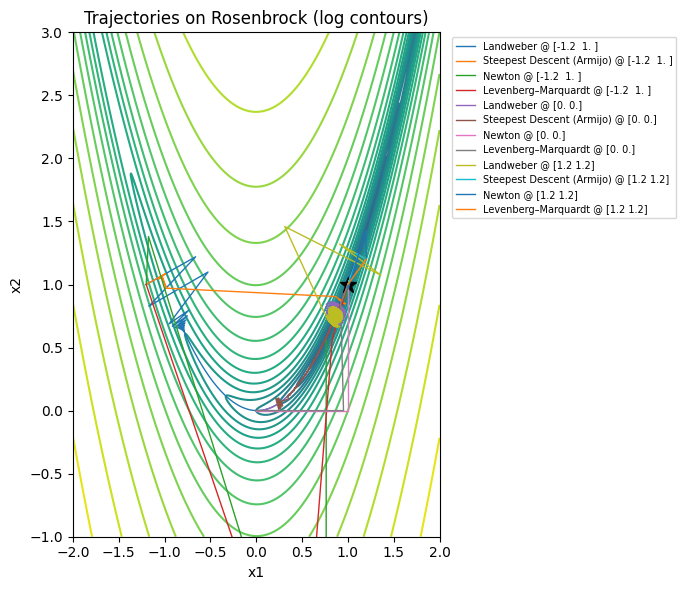

In [ ]:
# =========================
# Google Colab: HW#3 Variant B
# Unconstrained Nonlinear Optimization on Rosenbrock
# Methods: Landweber, Steepest Descent (line search), Newton, Levenberg–Marquardt
# Variant B: alpha = 0.005 (Landweber), mu = 0.05 (LM)
# =========================

import numpy as np

# ---------- Problem definition ----------
def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2

def grad_f(x):
    x1, x2 = x
    g1 = 2*(x1 - 1) - 400*x1*(x2 - x1**2)
    g2 = 200*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess_f(x):
    x1, x2 = x
    h11 = 2 - 400*(x2 - x1**2) + 800*(x1**2)
    h12 = -400*x1
    h22 = 200.0
    return np.array([[h11, h12],
                     [h12, h22]], dtype=float)

def F(x):
    x1, x2 = x
    return np.array([1 - x1, 10.0*(x2 - x1**2)], dtype=float)

def J(x):
    x1, x2 = x
    # Jacobian of F:
    # F1 = 1 - x1        => dF1/dx1 = -1, dF1/dx2 = 0
    # F2 = 10(x2 - x1^2) => dF2/dx1 = -20 x1, dF2/dx2 = 10
    return np.array([[-1.0,      0.0],
                     [-20.0*x1, 10.0]], dtype=float)

def norm2(v):
    return float(np.linalg.norm(v, ord=2))

def run_template(method_name, x0, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    """
    Generic runner: expects a 'step_fn' returning (x_next, info_dict)
    We'll implement per-method runners separately for clarity.
    """
    raise NotImplementedError

def summarize_run(hist):
    # hist: dict with keys: x_path, f_path, status, iters, extra
    x_final = hist["x_path"][-1]
    return {
        "status": hist["status"],
        "iters": hist["iters"],
        "x_final": x_final,
        "f_final": hist["f_path"][-1],
        "grad_norm": norm2(grad_f(x_final)),
        **hist.get("extra", {})
    }

#  Method 1: Landweber
def landweber(x0, alpha=0.005, max_iter=20000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        # x_{k+1} = x_k - alpha * J^T F
        step = -alpha * (Jx.T @ Fx)
        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Landweber",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"alpha": alpha}
    }

# Method 2: Steepest Descent with Armijo backtracking
def steepest_descent(x0, max_iter=20000, tol_g=1e-8, tol_step=1e-12,
                     alpha0=1.0, c=1e-4, rho=0.5, max_ls=50):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    zigzag_hint = 0

    for k in range(max_iter):
        g = grad_f(x)
        gnorm = norm2(g)
        if gnorm < tol_g:
            status = "converged(grad)"
            break

        d = -g
        fx = f_path[-1]

        # Armijo backtracking line search
        alpha = alpha0
        ok = False
        for _ in range(max_ls):
            x_try = x + alpha * d
            if f(x_try) <= fx + c * alpha * (g @ d):
                ok = True
                break
            alpha *= rho

        if not ok:
            status = "line_search_failed"
            break

        step = alpha * d
        x_new = x + step

        # crude zig-zag indicator: if direction changes a lot
        if k >= 1:
            prev_step = x_path[-1] - x_path[-2]
            if norm2(prev_step) > 0 and norm2(step) > 0:
                cosang = float((prev_step @ step) / (norm2(prev_step)*norm2(step)))
                if cosang < -0.2:
                    zigzag_hint += 1

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Steepest Descent (Armijo)",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"zigzag_events": zigzag_hint}
    }

# Method 3: Newton
def newton_method(x0, max_iter=200, tol_g=1e-10, tol_step=1e-12, damping=1.0):
    """
    Plain Newton (can fail). Optional simple damping factor (1.0 = none).
    """
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    failures = 0

    for k in range(max_iter):
        g = grad_f(x)
        if norm2(g) < tol_g:
            status = "converged(grad)"
            break

        H = hess_f(x)

        try:
            # Solve H p = g; step = -p
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            status = "hessian_singular"
            failures += 1
            break

        step = -damping * p
        x_new = x + step

        # If f explodes, mark unstable and stop (assignment says it's OK if it fails)
        if not np.isfinite(f(x_new)) or f(x_new) > 1e12:
            status = "unstable(diverged)"
            break

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Newton",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"damping": damping, "failures": failures}
    }

# Method 4: Levenberg–Marquardt
def levenberg_marquardt(x0, mu=0.05, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    I = np.eye(2, dtype=float)

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        JTJ = Jx.T @ Jx
        g_ls = Jx.T @ Fx  # gradient of (1/2)||F||^2 up to constant; fine for stopping

        # step = -(JTJ + mu I)^{-1} J^T F
        A = JTJ + mu * I
        try:
            step = -np.linalg.solve(A, g_ls)
        except np.linalg.LinAlgError:
            status = "linear_solve_failed"
            break

        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Levenberg–Marquardt",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"mu": mu}
    }

# Run all methods on all initial points
initial_points = [
    np.array([-1.2, 1.0]),
    np.array([ 0.0, 0.0]),
    np.array([ 1.2, 1.2]),
]

alpha_B = 0.005
mu_B = 0.05

runs = []
for x0 in initial_points:
    runs.append(landweber(x0, alpha=alpha_B))
    runs.append(steepest_descent(x0))
    runs.append(newton_method(x0))  # plain Newton; allowed to fail
    runs.append(levenberg_marquardt(x0, mu=mu_B))

# Print a compact results table
def fmt(v, nd=6):
    if isinstance(v, (float, np.floating)):
        return f"{v:.{nd}g}"
    return str(v)

print("=== Results (Variant B) ===")
print("Columns: method | x0 | status | iters | f_final | ||grad|| | x_final")
for r in runs:
    s = summarize_run(r)
    x0 = r["x0"]
    print(
        f"{r['method']:<24} | "
        f"[{x0[0]:>5.2f}, {x0[1]:>5.2f}] | "
        f"{s['status']:<18} | "
        f"{s['iters']:>6d} | "
        f"{fmt(s['f_final'], 8):>10} | "
        f"{fmt(s['grad_norm'], 8):>10} | "
        f"[{s['x_final'][0]:.6f}, {s['x_final'][1]:.6f}]"
    )


import matplotlib.pyplot as plt

# Contour plot of Rosenbrock
x1 = np.linspace(-2, 2, 600)
x2 = np.linspace(-1, 3, 600)
X1, X2 = np.meshgrid(x1, x2)
Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

plt.figure(figsize=(7,6))
plt.contour(X1, X2, np.log10(Z + 1e-3), levels=30)
plt.plot(1, 1, 'k*', markersize=12)

for r in runs:
    path = np.array(r["x_path"])
    plt.plot(path[:,0], path[:,1], linewidth=1, label=f"{r['method']} @ {r['x0']}")

plt.xlim(-2, 2)
plt.ylim(-1, 3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Trajectories on Rosenbrock (log contours)")
plt.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

=== Results (Variant B) ===
Columns: method | x0 | status | iters | f_final | ||grad|| | x_final
Landweber                | [-1.20,  1.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [-1.20,  1.00] | converged(grad)    |  19435 | 6.106586e-17 | 9.996831e-09 | [1.000000, 1.000000]
Newton                   | [-1.20,  1.00] | converged(grad)    |      7 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [-1.20,  1.00] | converged(grad)    |     13 | 1.9348304e-17 | 3.9311457e-09 | [1.000000, 1.000000]
Landweber                | [ 0.00,  0.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [ 0.00,  0.00] | max_iter           |  20000 | 1.3710153e-16 | 2.4931985e-08 | [1.000000, 1.000000]
Newton                   | [ 0.00,  0.00] | converged(grad)    |      2 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [ 0.00,  0.

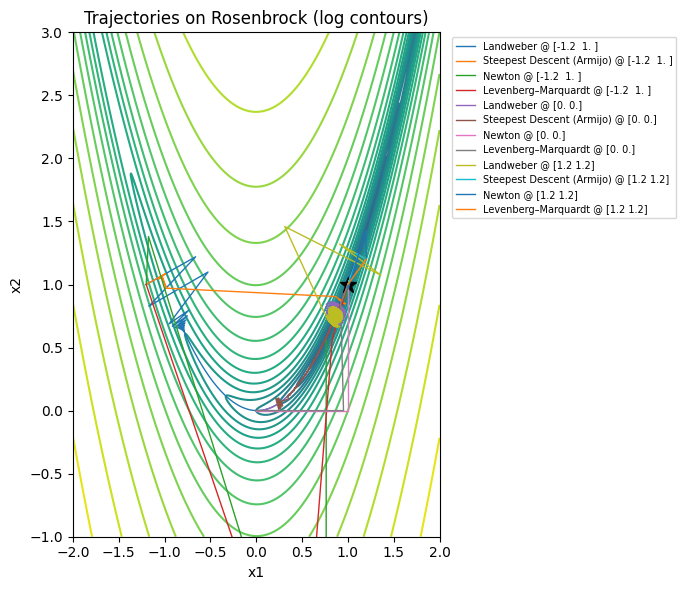

In [ ]:
# =========================
# Google Colab: HW#3 Variant B
# Unconstrained Nonlinear Optimization on Rosenbrock
# Methods: Landweber, Steepest Descent (line search), Newton, Levenberg–Marquardt
# Variant B: alpha = 0.005 (Landweber), mu = 0.05 (LM)
# =========================

import numpy as np

# ---------- Problem definition ----------
def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2

def grad_f(x):
    x1, x2 = x
    g1 = 2*(x1 - 1) - 400*x1*(x2 - x1**2)
    g2 = 200*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess_f(x):
    x1, x2 = x
    h11 = 2 - 400*(x2 - x1**2) + 800*(x1**2)
    h12 = -400*x1
    h22 = 200.0
    return np.array([[h11, h12],
                     [h12, h22]], dtype=float)

def F(x):
    x1, x2 = x
    return np.array([1 - x1, 10.0*(x2 - x1**2)], dtype=float)

def J(x):
    x1, x2 = x
    # Jacobian of F:
    # F1 = 1 - x1        => dF1/dx1 = -1, dF1/dx2 = 0
    # F2 = 10(x2 - x1^2) => dF2/dx1 = -20 x1, dF2/dx2 = 10
    return np.array([[-1.0,      0.0],
                     [-20.0*x1, 10.0]], dtype=float)

def norm2(v):
    return float(np.linalg.norm(v, ord=2))

def run_template(method_name, x0, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    """
    Generic runner: expects a 'step_fn' returning (x_next, info_dict)
    We'll implement per-method runners separately for clarity.
    """
    raise NotImplementedError

def summarize_run(hist):
    # hist: dict with keys: x_path, f_path, status, iters, extra
    x_final = hist["x_path"][-1]
    return {
        "status": hist["status"],
        "iters": hist["iters"],
        "x_final": x_final,
        "f_final": hist["f_path"][-1],
        "grad_norm": norm2(grad_f(x_final)),
        **hist.get("extra", {})
    }

#  Method 1: Landweber
def landweber(x0, alpha=0.005, max_iter=20000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        # x_{k+1} = x_k - alpha * J^T F
        step = -alpha * (Jx.T @ Fx)
        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Landweber",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"alpha": alpha}
    }

# Method 2: Steepest Descent with Armijo backtracking
def steepest_descent(x0, max_iter=20000, tol_g=1e-8, tol_step=1e-12,
                     alpha0=1.0, c=1e-4, rho=0.5, max_ls=50):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    zigzag_hint = 0

    for k in range(max_iter):
        g = grad_f(x)
        gnorm = norm2(g)
        if gnorm < tol_g:
            status = "converged(grad)"
            break

        d = -g
        fx = f_path[-1]

        # Armijo backtracking line search
        alpha = alpha0
        ok = False
        for _ in range(max_ls):
            x_try = x + alpha * d
            if f(x_try) <= fx + c * alpha * (g @ d):
                ok = True
                break
            alpha *= rho

        if not ok:
            status = "line_search_failed"
            break

        step = alpha * d
        x_new = x + step

        # crude zig-zag indicator: if direction changes a lot
        if k >= 1:
            prev_step = x_path[-1] - x_path[-2]
            if norm2(prev_step) > 0 and norm2(step) > 0:
                cosang = float((prev_step @ step) / (norm2(prev_step)*norm2(step)))
                if cosang < -0.2:
                    zigzag_hint += 1

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Steepest Descent (Armijo)",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"zigzag_events": zigzag_hint}
    }

# Method 3: Newton
def newton_method(x0, max_iter=200, tol_g=1e-10, tol_step=1e-12, damping=1.0):
    """
    Plain Newton (can fail). Optional simple damping factor (1.0 = none).
    """
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    failures = 0

    for k in range(max_iter):
        g = grad_f(x)
        if norm2(g) < tol_g:
            status = "converged(grad)"
            break

        H = hess_f(x)

        try:
            # Solve H p = g; step = -p
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            status = "hessian_singular"
            failures += 1
            break

        step = -damping * p
        x_new = x + step

        # If f explodes, mark unstable and stop (assignment says it's OK if it fails)
        if not np.isfinite(f(x_new)) or f(x_new) > 1e12:
            status = "unstable(diverged)"
            break

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Newton",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"damping": damping, "failures": failures}
    }

# Method 4: Levenberg–Marquardt
def levenberg_marquardt(x0, mu=0.05, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    I = np.eye(2, dtype=float)

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        JTJ = Jx.T @ Jx
        g_ls = Jx.T @ Fx  # gradient of (1/2)||F||^2 up to constant; fine for stopping

        # step = -(JTJ + mu I)^{-1} J^T F
        A = JTJ + mu * I
        try:
            step = -np.linalg.solve(A, g_ls)
        except np.linalg.LinAlgError:
            status = "linear_solve_failed"
            break

        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Levenberg–Marquardt",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"mu": mu}
    }

# Run all methods on all initial points
initial_points = [
    np.array([-1.2, 1.0]),
    np.array([ 0.0, 0.0]),
    np.array([ 1.2, 1.2]),
]

alpha_B = 0.005
mu_B = 0.05

runs = []
for x0 in initial_points:
    runs.append(landweber(x0, alpha=alpha_B))
    runs.append(steepest_descent(x0))
    runs.append(newton_method(x0))  # plain Newton; allowed to fail
    runs.append(levenberg_marquardt(x0, mu=mu_B))

# Print a compact results table
def fmt(v, nd=6):
    if isinstance(v, (float, np.floating)):
        return f"{v:.{nd}g}"
    return str(v)

print("=== Results (Variant B) ===")
print("Columns: method | x0 | status | iters | f_final | ||grad|| | x_final")
for r in runs:
    s = summarize_run(r)
    x0 = r["x0"]
    print(
        f"{r['method']:<24} | "
        f"[{x0[0]:>5.2f}, {x0[1]:>5.2f}] | "
        f"{s['status']:<18} | "
        f"{s['iters']:>6d} | "
        f"{fmt(s['f_final'], 8):>10} | "
        f"{fmt(s['grad_norm'], 8):>10} | "
        f"[{s['x_final'][0]:.6f}, {s['x_final'][1]:.6f}]"
    )


import matplotlib.pyplot as plt

# Contour plot of Rosenbrock
x1 = np.linspace(-2, 2, 600)
x2 = np.linspace(-1, 3, 600)
X1, X2 = np.meshgrid(x1, x2)
Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

plt.figure(figsize=(7,6))
plt.contour(X1, X2, np.log10(Z + 1e-3), levels=30)
plt.plot(1, 1, 'k*', markersize=12)

for r in runs:
    path = np.array(r["x_path"])
    plt.plot(path[:,0], path[:,1], linewidth=1, label=f"{r['method']} @ {r['x0']}")

plt.xlim(-2, 2)
plt.ylim(-1, 3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Trajectories on Rosenbrock (log contours)")
plt.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

=== Results (Variant B) ===
Columns: method | x0 | status | iters | f_final | ||grad|| | x_final
Landweber                | [-1.20,  1.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [-1.20,  1.00] | converged(grad)    |  19435 | 6.106586e-17 | 9.996831e-09 | [1.000000, 1.000000]
Newton                   | [-1.20,  1.00] | converged(grad)    |      7 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [-1.20,  1.00] | converged(grad)    |     13 | 1.9348304e-17 | 3.9311457e-09 | [1.000000, 1.000000]
Landweber                | [ 0.00,  0.00] | max_iter           |  20000 |  0.1789115 |  15.801217 | [0.847832, 0.758284]
Steepest Descent (Armijo) | [ 0.00,  0.00] | max_iter           |  20000 | 1.3710153e-16 | 2.4931985e-08 | [1.000000, 1.000000]
Newton                   | [ 0.00,  0.00] | converged(grad)    |      2 |          0 |          0 | [1.000000, 1.000000]
Levenberg–Marquardt      | [ 0.00,  0.

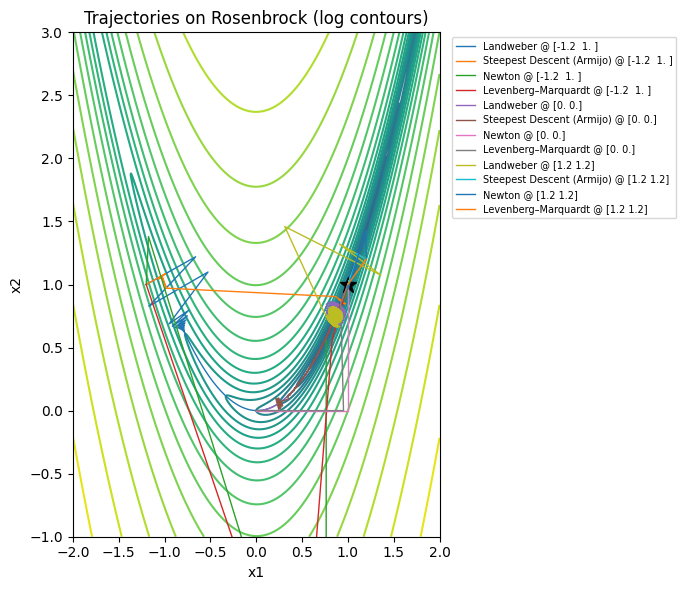

In [ ]:
# =========================
# Google Colab: HW#3 Variant B
# Unconstrained Nonlinear Optimization on Rosenbrock
# Methods: Landweber, Steepest Descent (line search), Newton, Levenberg–Marquardt
# Variant B: alpha = 0.005 (Landweber), mu = 0.05 (LM)
# =========================

import numpy as np

# ---------- Problem definition ----------
def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2

def grad_f(x):
    x1, x2 = x
    g1 = 2*(x1 - 1) - 400*x1*(x2 - x1**2)
    g2 = 200*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess_f(x):
    x1, x2 = x
    h11 = 2 - 400*(x2 - x1**2) + 800*(x1**2)
    h12 = -400*x1
    h22 = 200.0
    return np.array([[h11, h12],
                     [h12, h22]], dtype=float)

def F(x):
    x1, x2 = x
    return np.array([1 - x1, 10.0*(x2 - x1**2)], dtype=float)

def J(x):
    x1, x2 = x
    # Jacobian of F:
    # F1 = 1 - x1        => dF1/dx1 = -1, dF1/dx2 = 0
    # F2 = 10(x2 - x1^2) => dF2/dx1 = -20 x1, dF2/dx2 = 10
    return np.array([[-1.0,      0.0],
                     [-20.0*x1, 10.0]], dtype=float)

def norm2(v):
    return float(np.linalg.norm(v, ord=2))

def run_template(method_name, x0, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    """
    Generic runner: expects a 'step_fn' returning (x_next, info_dict)
    We'll implement per-method runners separately for clarity.
    """
    raise NotImplementedError

def summarize_run(hist):
    # hist: dict with keys: x_path, f_path, status, iters, extra
    x_final = hist["x_path"][-1]
    return {
        "status": hist["status"],
        "iters": hist["iters"],
        "x_final": x_final,
        "f_final": hist["f_path"][-1],
        "grad_norm": norm2(grad_f(x_final)),
        **hist.get("extra", {})
    }

#  Method 1: Landweber
def landweber(x0, alpha=0.005, max_iter=20000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        # x_{k+1} = x_k - alpha * J^T F
        step = -alpha * (Jx.T @ Fx)
        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Landweber",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"alpha": alpha}
    }

# Method 2: Steepest Descent with Armijo backtracking
def steepest_descent(x0, max_iter=20000, tol_g=1e-8, tol_step=1e-12,
                     alpha0=1.0, c=1e-4, rho=0.5, max_ls=50):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    zigzag_hint = 0

    for k in range(max_iter):
        g = grad_f(x)
        gnorm = norm2(g)
        if gnorm < tol_g:
            status = "converged(grad)"
            break

        d = -g
        fx = f_path[-1]

        # Armijo backtracking line search
        alpha = alpha0
        ok = False
        for _ in range(max_ls):
            x_try = x + alpha * d
            if f(x_try) <= fx + c * alpha * (g @ d):
                ok = True
                break
            alpha *= rho

        if not ok:
            status = "line_search_failed"
            break

        step = alpha * d
        x_new = x + step

        # crude zig-zag indicator: if direction changes a lot
        if k >= 1:
            prev_step = x_path[-1] - x_path[-2]
            if norm2(prev_step) > 0 and norm2(step) > 0:
                cosang = float((prev_step @ step) / (norm2(prev_step)*norm2(step)))
                if cosang < -0.2:
                    zigzag_hint += 1

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Steepest Descent (Armijo)",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"zigzag_events": zigzag_hint}
    }

# Method 3: Newton
def newton_method(x0, max_iter=200, tol_g=1e-10, tol_step=1e-12, damping=1.0):
    """
    Plain Newton (can fail). Optional simple damping factor (1.0 = none).
    """
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"
    failures = 0

    for k in range(max_iter):
        g = grad_f(x)
        if norm2(g) < tol_g:
            status = "converged(grad)"
            break

        H = hess_f(x)

        try:
            # Solve H p = g; step = -p
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            status = "hessian_singular"
            failures += 1
            break

        step = -damping * p
        x_new = x + step

        # If f explodes, mark unstable and stop (assignment says it's OK if it fails)
        if not np.isfinite(f(x_new)) or f(x_new) > 1e12:
            status = "unstable(diverged)"
            break

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Newton",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"damping": damping, "failures": failures}
    }

# Method 4: Levenberg–Marquardt
def levenberg_marquardt(x0, mu=0.05, max_iter=5000, tol_g=1e-8, tol_step=1e-12):
    x = np.array(x0, dtype=float)
    x_path = [x.copy()]
    f_path = [f(x)]
    status = "max_iter"

    I = np.eye(2, dtype=float)

    for k in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        JTJ = Jx.T @ Jx
        g_ls = Jx.T @ Fx  # gradient of (1/2)||F||^2 up to constant; fine for stopping

        # step = -(JTJ + mu I)^{-1} J^T F
        A = JTJ + mu * I
        try:
            step = -np.linalg.solve(A, g_ls)
        except np.linalg.LinAlgError:
            status = "linear_solve_failed"
            break

        x_new = x + step

        x_path.append(x_new.copy())
        f_path.append(f(x_new))

        if norm2(step) < tol_step:
            status = "converged(step)"
            x = x_new
            break

        if norm2(grad_f(x_new)) < tol_g:
            status = "converged(grad)"
            x = x_new
            break

        x = x_new

    return {
        "method": "Levenberg–Marquardt",
        "x0": np.array(x0, dtype=float),
        "x_path": x_path,
        "f_path": f_path,
        "iters": len(x_path) - 1,
        "status": status,
        "extra": {"mu": mu}
    }

# Run all methods on all initial points
initial_points = [
    np.array([-1.2, 1.0]),
    np.array([ 0.0, 0.0]),
    np.array([ 1.2, 1.2]),
]

alpha_B = 0.005
mu_B = 0.05

runs = []
for x0 in initial_points:
    runs.append(landweber(x0, alpha=alpha_B))
    runs.append(steepest_descent(x0))
    runs.append(newton_method(x0))  # plain Newton; allowed to fail
    runs.append(levenberg_marquardt(x0, mu=mu_B))

# Print a compact results table
def fmt(v, nd=6):
    if isinstance(v, (float, np.floating)):
        return f"{v:.{nd}g}"
    return str(v)

print("=== Results (Variant B) ===")
print("Columns: method | x0 | status | iters | f_final | ||grad|| | x_final")
for r in runs:
    s = summarize_run(r)
    x0 = r["x0"]
    print(
        f"{r['method']:<24} | "
        f"[{x0[0]:>5.2f}, {x0[1]:>5.2f}] | "
        f"{s['status']:<18} | "
        f"{s['iters']:>6d} | "
        f"{fmt(s['f_final'], 8):>10} | "
        f"{fmt(s['grad_norm'], 8):>10} | "
        f"[{s['x_final'][0]:.6f}, {s['x_final'][1]:.6f}]"
    )


import matplotlib.pyplot as plt

# Contour plot of Rosenbrock
x1 = np.linspace(-2, 2, 600)
x2 = np.linspace(-1, 3, 600)
X1, X2 = np.meshgrid(x1, x2)
Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

plt.figure(figsize=(7,6))
plt.contour(X1, X2, np.log10(Z + 1e-3), levels=30)
plt.plot(1, 1, 'k*', markersize=12)

for r in runs:
    path = np.array(r["x_path"])
    plt.plot(path[:,0], path[:,1], linewidth=1, label=f"{r['method']} @ {r['x0']}")

plt.xlim(-2, 2)
plt.ylim(-1, 3)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Trajectories on Rosenbrock (log contours)")
plt.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

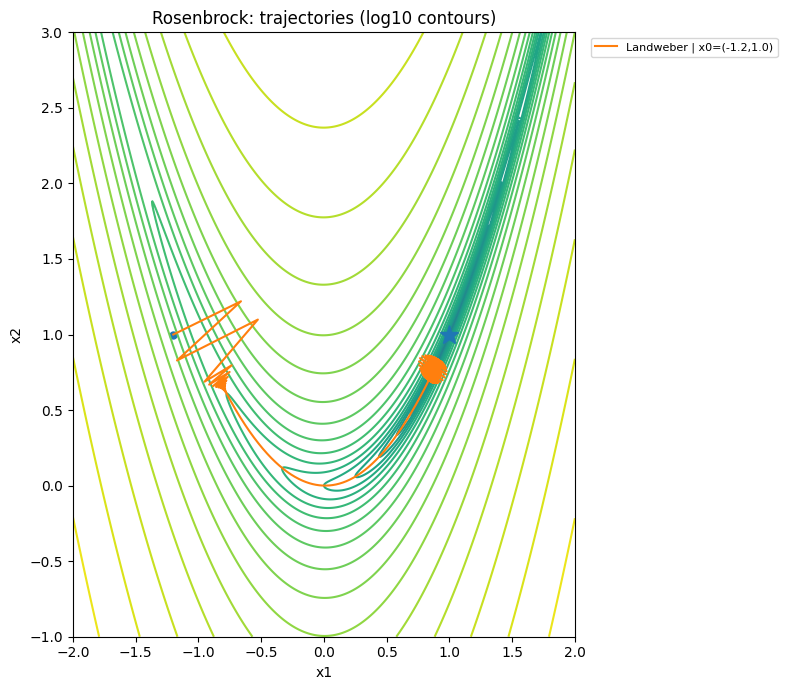

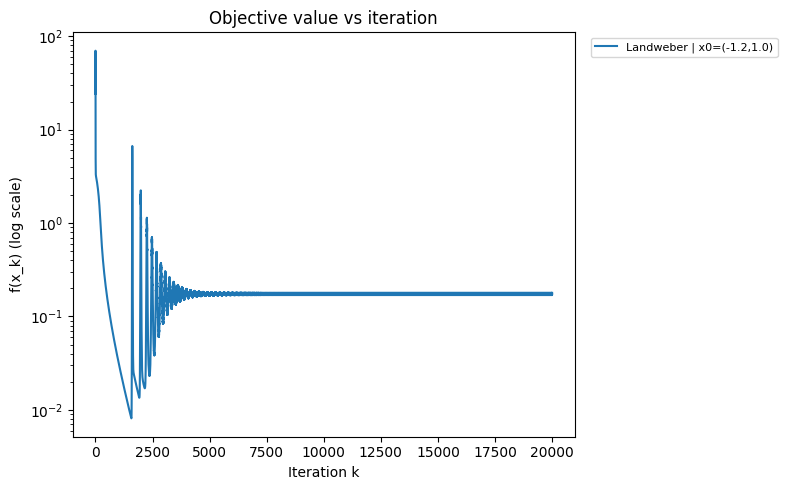

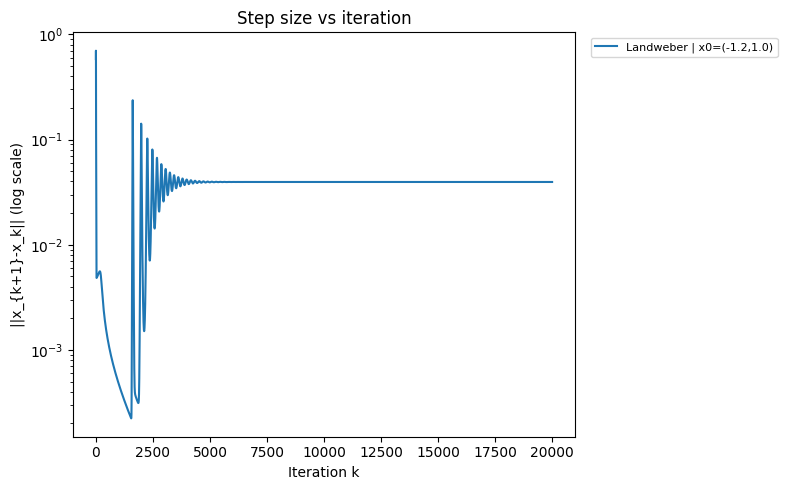

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def f(x):
    x1, x2 = x
    return (1 - x1)**2 + 100.0*(x2 - x1**2)**2


# ---------- 1) Trajectories on Rosenbrock contours ----------
def plot_trajectories(runs, xlim=(-2, 2), ylim=(-1, 3), grid_n=500, log_contours=True):
    x1 = np.linspace(xlim[0], xlim[1], grid_n)
    x2 = np.linspace(ylim[0], ylim[1], grid_n)
    X1, X2 = np.meshgrid(x1, x2)
    Z = (1 - X1)**2 + 100*(X2 - X1**2)**2

    plt.figure(figsize=(8, 7))

    if log_contours:
        # log-scale contours make the narrow valley visible
        plt.contour(X1, X2, np.log10(Z + 1e-12), levels=35)
        plt.title("Rosenbrock: trajectories (log10 contours)")
    else:
        plt.contour(X1, X2, Z, levels=35)
        plt.title("Rosenbrock: trajectories (contours)")

    # global minimizer
    plt.plot(1, 1, marker="*", markersize=14)

    for r in runs:
        path = np.array(r["x_path"], dtype=float)
        if len(path) < 2:
            continue
        label = f'{r["method"]} | x0=({r["x0"][0]:.1f},{r["x0"][1]:.1f})'
        plt.plot(path[:, 0], path[:, 1], linewidth=1.5, label=label)
        plt.scatter(path[0, 0], path[0, 1], s=25)         # start
        plt.scatter(path[-1, 0], path[-1, 1], s=25)       # end

    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()


# ---------- 2) f(x_k) vs iteration (semilogy) ----------
def plot_objective_vs_iter(runs):
    plt.figure(figsize=(8, 5))
    for r in runs:
        fvals = np.array(r["f_path"], dtype=float)
        # Avoid log(0)
        fvals = np.maximum(fvals, 1e-16)
        label = f'{r["method"]} | x0=({r["x0"][0]:.1f},{r["x0"][1]:.1f})'
        plt.semilogy(fvals, label=label)
    plt.xlabel("Iteration k")
    plt.ylabel("f(x_k) (log scale)")
    plt.title("Objective value vs iteration")
    plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()


# ---------- 3) Step length ||x_{k+1}-x_k|| vs iteration (semilogy) ----------
def plot_step_norm_vs_iter(runs):
    plt.figure(figsize=(8, 5))
    for r in runs:
        path = np.array(r["x_path"], dtype=float)
        if len(path) < 2:
            continue
        steps = np.linalg.norm(path[1:] - path[:-1], axis=1)
        steps = np.maximum(steps, 1e-16)
        label = f'{r["method"]} | x0=({r["x0"][0]:.1f},{r["x0"][1]:.1f})'
        plt.semilogy(steps, label=label)
    plt.xlabel("Iteration k")
    plt.ylabel("||x_{k+1}-x_k|| (log scale)")
    plt.title("Step size vs iteration")
    plt.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()


# ---------- 4) Convenience: plot per-initial-point (cleaner figures) ----------
def group_runs_by_x0(runs):
    groups = {}
    for r in runs:
        key = (float(r["x0"][0]), float(r["x0"][1]))
        groups.setdefault(key, []).append(r)
    return groups

def plot_all_groups(runs):
    groups = group_runs_by_x0(runs)
    for x0, rs in groups.items():
        print(f"\n--- Initial point x0 = {x0} ---")
        plot_trajectories(rs)
        plot_objective_vs_iter(rs)
        plot_step_norm_vs_iter(rs)


# PLOTS

plot_trajectories(runs)          # big combined trajectory plot
plot_objective_vs_iter(runs)     # convergence curves
plot_step_norm_vs_iter(runs)     # step-size curves


